<a href="https://colab.research.google.com/github/kalind789/PyTorch_Vision_Learning/blob/main/OptimizedCNNImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as DataLoader

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
TRAINLOADER = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
TESTLOADER = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
print(device)

cuda:0


In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.pool = nn.MaxPool2d(2, 2)

        # First thing I want to try is scaling the network up to 3 convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=1)

        # To do so, I also need to recalculate the dimensions for the flat layer
        self.fc1 = nn.Linear(32 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

tut_net = MyNet().to(device)

### Math

What I needed to do for this was:

Conv Layer Output Dim: $H_{\text{out}} = \lfloor \frac{ H_{\text{in}} - K + 2P}{S} \rfloor + 1$, where $K = \text{Kernel Size}$, $P = \text{Padding}$, and $S = \text{Stride}$ (default 1).

Assuming a $32 \times 32$ input, your $K=3$, $P=1$, and $S=1$ results in:

$$\text{Conv Output} = \lfloor \frac{32 - 3 + 2(1)}{1} \rfloor + 1 = \mathbf{32}$$

Then, we get a new dim from the pooling: $H_{\text{out}} = \lfloor \frac{ H_{\text{in}} - K}{S} \rfloor + 1$ for pooling, assuming a standard MaxPool, $\text{Kernel} (K) = 2$ and $\text{Stride} (S) = 2$.

For us this is:

$$\text{Pool Output} = \lfloor \frac{32 - 2}{2} \rfloor + 1 = \mathbf{16}$$

This means that after the first block ($\text{conv1} \to \text{pool}$), the image size is $16 \times 16$.

If we assume the same sequence of (Conv $\to$ Pool) for the second block, and only Conv for the third:

1.  **After $\text{conv2} \to \text{pool}$:** $16 \to \mathbf{8}$
2.  **After $\text{conv3}$ (No Pool):** $8 \to \mathbf{8}$

SO what's the flatten layer?

$$\text{Final Flatten Input} = \text{Final Channels} \times \text{Final Height} \times \text{Final Width}$$

$$\text{Flatten Input} = 32 \times 8 \times 8 = \mathbf{2048}$$

In [ ]:
data_dict = {
    'loss': [],
    'iteration': []
}

def train_model(model, criterion, optimizer, trainloader, num_epochs=5):
  global_step = 0
  for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data[0].to(device), data[1].to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % 200 == 199:    # print every 200 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
          data_dict['loss'].append(running_loss/200)
          data_dict['iteration'].append(global_step)
          running_loss = 0.0

      global_step += 1

  print('Finished Training')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tut_net.parameters(), lr=0.001)

In [ ]:
train_model(model=tut_net, criterion=criterion, optimizer=optimizer, trainloader=TRAINLOADER, num_epochs=2)

[1,   200] loss: 2.195
[1,   400] loss: 2.035
[1,   600] loss: 1.951
[1,   800] loss: 1.869
[1,  1000] loss: 1.794
[1,  1200] loss: 1.732
[1,  1400] loss: 1.677
[1,  1600] loss: 1.652
[1,  1800] loss: 1.656
[1,  2000] loss: 1.590
[1,  2200] loss: 1.563
[1,  2400] loss: 1.605
[1,  2600] loss: 1.526
[1,  2800] loss: 1.517
[1,  3000] loss: 1.519
[1,  3200] loss: 1.550
[1,  3400] loss: 1.493
[1,  3600] loss: 1.527
[1,  3800] loss: 1.481
[1,  4000] loss: 1.451
[1,  4200] loss: 1.451
[1,  4400] loss: 1.483
[1,  4600] loss: 1.476
[1,  4800] loss: 1.459
[1,  5000] loss: 1.426
[1,  5200] loss: 1.444
[1,  5400] loss: 1.431
[1,  5600] loss: 1.454
[1,  5800] loss: 1.382
[1,  6000] loss: 1.381
[1,  6200] loss: 1.419
[2,   200] loss: 1.357
[2,   400] loss: 1.372
[2,   600] loss: 1.350
[2,   800] loss: 1.320
[2,  1000] loss: 1.350
[2,  1200] loss: 1.330
[2,  1400] loss: 1.376
[2,  1600] loss: 1.297
[2,  1800] loss: 1.325
[2,  2000] loss: 1.273
[2,  2200] loss: 1.335
[2,  2400] loss: 1.300
[2,  2600] 

In [ ]:
def test_model(model, criterion, testloader, num_epochs=2):
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  model.eval()
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
test_model(tut_net, criterion=criterion, testloader=TESTLOADER)

Accuracy of the network on the 10000 test images: 55 %


In [ ]:
import pandas as pd
df = pd.DataFrame(data_dict)

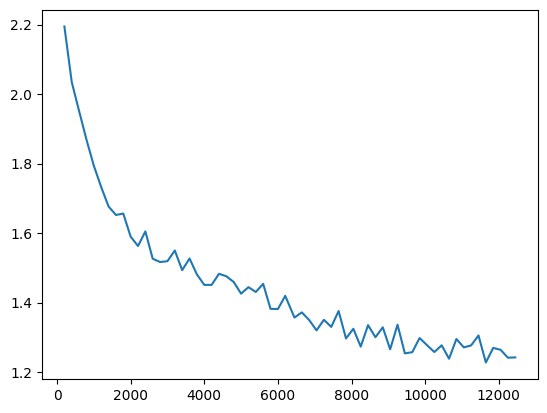

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df['iteration'], df['loss'])
plt.show()